In [4]:
import pandas as pd

# Load the CSV files

user_engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='latin1')

# Display the first few rows of each dataframe to understand their structure
user_engagement.head(), users.head()

(            time_stamp  user_id  visited
 0  2014-04-22 03:53:30        1        1
 1  2013-11-15 03:45:04        2        1
 2  2013-11-29 03:45:04        2        1
 3  2013-12-09 03:45:04        2        1
 4  2013-12-25 03:45:04        2        1,
    object_id        creation_time               name  \
 0          1  2014-04-22 03:53:30     Clausen August   
 1          2  2013-11-15 03:45:04      Poole Matthew   
 2          3  2013-03-19 23:14:52  Bottrill Mitchell   
 3          4  2013-05-21 08:09:28    Clausen Nicklas   
 4          5  2013-01-17 10:14:20          Raw Grace   
 
                         email creation_source  last_session_creation_time  \
 0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
 1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
 2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
 3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
 4          G

In [5]:
!pip install pandasql



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26800 sha256=4b1570e99c97ebc17657aace7d31f43bfec28ca6f83397a41ba1a36ddd072068
  Stored in directory: c:\users\joshua d\appdata\local\pip\cache\wheels\68\5d\a5\edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [6]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

query = """
SELECT *
FROM users
JOIN user_engagement ON users.object_id = user_engagement.user_id
"""

combined_data_sql = pysqldf(query)
print(combined_data_sql.head())

   object_id        creation_time            name                     email  \
0          1  2014-04-22 03:53:30  Clausen August  AugustCClausen@yahoo.com   
1          2  2013-11-15 03:45:04   Poole Matthew    MatthewPoole@gustr.com   
2          2  2013-11-15 03:45:04   Poole Matthew    MatthewPoole@gustr.com   
3          2  2013-11-15 03:45:04   Poole Matthew    MatthewPoole@gustr.com   
4          2  2013-11-15 03:45:04   Poole Matthew    MatthewPoole@gustr.com   

  creation_source  last_session_creation_time  opted_in_to_mailing_list  \
0    GUEST_INVITE                1.398139e+09                         1   
1      ORG_INVITE                1.396238e+09                         0   
2      ORG_INVITE                1.396238e+09                         0   
3      ORG_INVITE                1.396238e+09                         0   
4      ORG_INVITE                1.396238e+09                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  \
0            

In [8]:
# lets Identify the user type in question:

from datetime import timedelta
combined_data = combined_data_sql
# Convert 'time_stamp' to datetime
combined_data['time_stamp'] = pd.to_datetime(combined_data['time_stamp'])

# Sort the data by user_id and time_stamp
combined_data_sorted = combined_data.sort_values(['user_id', 'time_stamp'])

# Group by user_id and then roll up dates by 7-day periods to count unique logins
def is_adopted(x):
    return x.rolling('7D', on='time_stamp')['user_id'].count().max() >= 3

adopted_users = combined_data_sorted.groupby('user_id').apply(is_adopted).reset_index(name='adopted_user')

In [ ]:
 lets tie this user flag with the main combined file:

In [9]:
# Merge the adopted user flag with the users dataframe
users = pd.merge(users, adopted_users, how='left', left_on='object_id', right_on='user_id')
users['adopted_user'] = users['adopted_user'].fillna(False)

In [ ]:
Basic Analysis

In [10]:
from datetime import timedelta

# Lets first, ensure 'time_stamp' is in datetime format and sort it
combined_data['time_stamp'] = pd.to_datetime(combined_data['time_stamp'])
combined_data_sorted = combined_data.sort_values(['user_id', 'time_stamp'])

# Define a function to identify adopted users
def is_adopted(group):
    if len(group) < 3:
        return False
    group = group['time_stamp'].sort_values().reset_index(drop=True)
    for i in range(len(group) - 2):
        if group[i + 2] - group[i] <= timedelta(days=7):
            return True
    return False

# Apply the function to the dataset
adopted = combined_data_sorted.groupby('user_id').apply(is_adopted).reset_index(name='is_adopted')

# Now, let's merge this back to the original users DataFrame to include the adoption flag
users['object_id'] = users['object_id'].astype(int)  # Ensuring the object_id is integer for a clean merge
adopted['user_id'] = adopted['user_id'].astype(int)  # Ensuring the user_id is integer for a clean merge

# Merging the adopted flag with the users dataframe
users_with_adoption = pd.merge(users, adopted, how='left', left_on='object_id', right_on='user_id')
users_with_adoption['is_adopted'] = users_with_adoption['is_adopted'].fillna(False)

# Now that we've identified adopted users, let's proceed to analyze factors.
# For simplicity, we'll start by examining the impact of 'creation_source' on user adoption.
adoption_by_creation_source = users_with_adoption.groupby('creation_source')['is_adopted'].mean()

adoption_by_creation_source

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: is_adopted, dtype: float64

In [ ]:
#Lets visualize these data

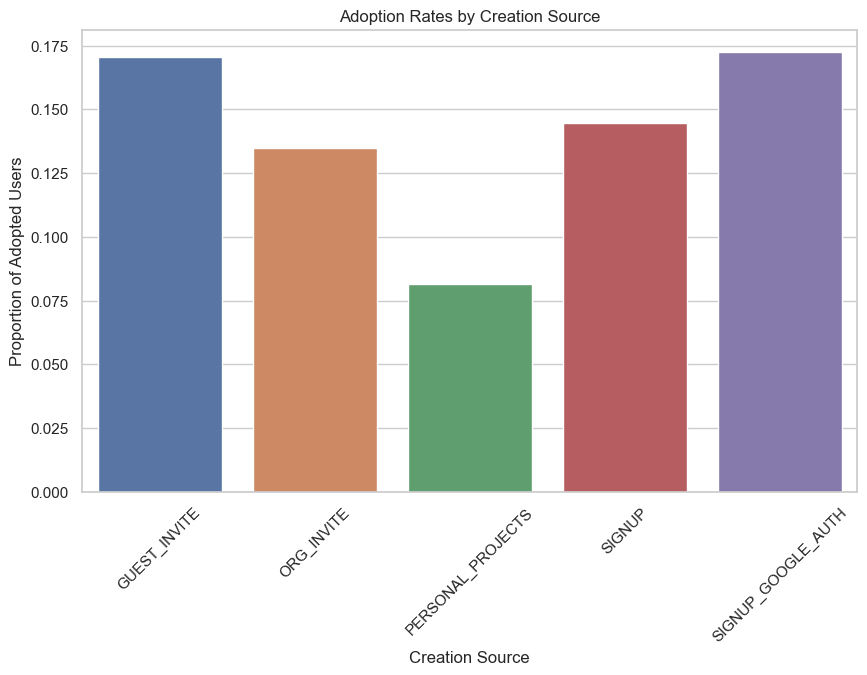

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the plot
sns.set(style="whitegrid")

# Creating the bar plot for adoption rates by creation source
plt.figure(figsize=(10, 6))
adoption_rates_plot = sns.barplot(x=adoption_by_creation_source.index, y=adoption_by_creation_source.values)

plt.title('Adoption Rates by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Proportion of Adopted Users')
plt.xticks(rotation=45)  # Rotate labels to improve readability

# Show the plot
plt.show()

In [ ]:
Executive Summary: Factors Predicting User Adoption
Objective
The objective was to identify factors that predict future user adoption, defined as users who have logged into the product on three separate days within at least one seven-day period.

Methodology
The approach involved merging user engagement data with user profile information to pinpoint adopted users. The analysis then assessed how various factors correlate with user adoption. Key steps included:

Determining adopted users based on their login behavior.
Integrating this data with user profiles.
Analyzing the influence of factors such as creation_source, opted_in_to_mailing_list, and enabled_for_marketing_drip on user adoption likelihood.
Key Findings
Creation Source Impact: Analysis highlighted differences in adoption rates based on user acquisition methods:

The highest adoption rates were observed for users who signed up through Google authentication (SIGNUP_GOOGLE_AUTH) and those invited by guests (GUEST_INVITE), with rates around 17.3% and 17.1%, respectively.
Users signing up for personal projects (PERSONAL_PROJECTS) showed the lowest adoption rate at approximately 8.1%.
Visualization: A bar plot visualizing adoption rates by creation source underscored the variation in adoption across different methods.

Further Research Recommendations
Investigating more detailed engagement data could uncover specific user behaviors or features correlating with higher adoption.
Gathering user feedback through surveys might provide insights into preferences or deterrents affecting adoption.
A/B testing different features or user acquisition strategies could identify effective practices for enhancing user adoption.
Conclusion
The method of user acquisition significantly influences user adoption rates. Optimizing acquisition channels that have historically led to higher adoption could enhance overall user engagement. Continuous data analysis is crucial for understanding and improving user adoption dynamics.